In [1]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, make_scorer, accuracy_score
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
dfr = pd.read_csv('./data/winequality-red.csv', sep=';')
target = 'quality'

### Splitting target and features

In [3]:
X = dfr.drop(columns=[target])
y = dfr[target]

### Splitting to train and test - We split 75% to train, and we stratify to balance the minority classes in the training and test set

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

### This function will help us understand if we improved after each step

In [5]:
def calculate_scores(y_true, y_pred):
    report = classification_report(
    y_true, y_pred, target_names=['3', '4', '5', '6', '7', '8'], output_dict=True
    )

    df_report = pd.DataFrame(report).transpose()

    df_report = df_report.drop(columns=['support'], errors='ignore')

    plt.figure(figsize=(10, 6))
    sns.heatmap(
        df_report.iloc[:-1, :].astype(float),
        annot=True, cmap="YlGnBu", cbar=True, fmt=".2f", linewidths=0.5,
    )

    plt.title('Figure 8: Classification Report', fontsize=16, weight='bold')
    plt.xlabel('Metrics', fontsize=14)
    plt.ylabel('Classes', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12, rotation=0)
    plt.tight_layout()

    plt.show()


# Basic Pipeline:

In [6]:
def basic_pipeline(X_train, y_train):
    model = XGBRegressor()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    return y_pred

In [7]:
def round_results(y_pred):
    #To get the actual qualitys
    y_pred_rounded = np.array([])
    for pred in y_pred:
        y_pred_rounded = np.append(y_pred_rounded, round(pred))

    y_pred_indexed = pd.Series(y_pred_rounded, y_test.index)

    return y_pred_indexed

In [8]:
y_pred = basic_pipeline(X_train, y_train)

### Simply rounding the results

In [9]:
y_pred_rounded = round_results(y_pred)

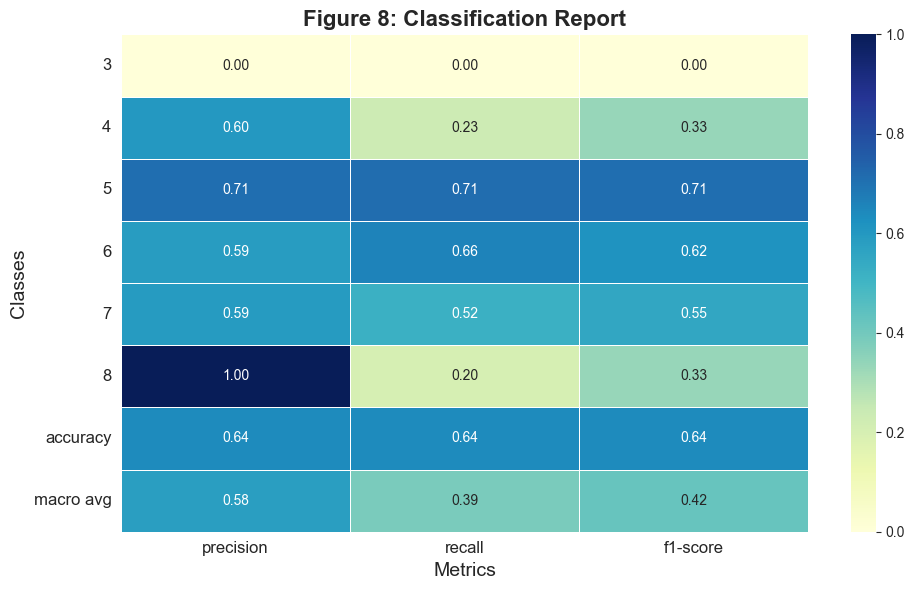

In [10]:
calculate_scores(y_test, y_pred_rounded)

# Key Takeaways from the Classification Report

## Class Performance:
- **Class 3:**
  - Poor performance with all metrics (`precision`, `recall`, and `f1-score`) being **0**.
  - The model failed to correctly classify any instances of this class.

- **Class 4:**
  - Struggles with low `precision` (**0.50**), `recall` (**0.23**), and `f1-score` (**0.32**).
  - Indicates difficulty in identifying this class correctly.

- **Class 5:**
  - Fairly balanced performance with `precision` (**0.70**), `recall` (**0.69**), and `f1-score` (**0.70**).
  - Shows reasonable performance for this class.

- **Class 6:**
  - Slightly better `recall` (**0.71**) but a moderate `f1-score` (**0.66**).
  - Indicates some imbalance in predictions.

- **Class 7:**
  - Moderate results with `precision` (**0.63**) but lower `recall` (**0.48**), leading to an `f1-score` of **0.55**.

- **Class 8:**
  - Perfect `precision` (**1.00**) but poor `recall` (**0.20**), resulting in a low `f1-score` (**0.33**).
  - Suggests overconfidence with very few true positives.

## Aggregate Metrics:
- **Accuracy:**
  - The overall accuracy is **0.65**, meaning roughly two-thirds of predictions were correct.

- **Macro Average:**
  - `Precision` (**0.57**), `recall` (**0.39**), and `f1-score` (**0.42**) reflect significant disparity in class-wise performance.

## Areas for Improvement:
- Significant attention is needed for **Class 3** and **Class 4**, as their metrics are substantially low.
- **Class 8** demonstrates overconfidence with high `precision` but very low `recall`, suggesting missed true positives.
- Balancing class-wise performance is critical, as shown by the discrepancy between the macro averages and overall accuracy.

## Balanced Classes:
- **Class 5** and **Class 6** exhibit the most balanced performance among the classes, indicating better predictability.

By addressing the weaknesses in specific classes, the overall performance of the classification model can be improved.


# Feature Engineering:

### Alcohol * Density

Following the Density formula, the alcohol content in terms of mass can be computed by multiplying alcohol, in the form of percentage by volume, with density. This will be treated as a new feature called alcohol_density.

In [11]:
X['alcohol density'] = X['alcohol'] * X['density']

## Total Acidity

Acidity is a characteristic determined by the total sum of acids that a sample contains. It is one of the important elements to monitor during winemaking because they give us an indication of what is going on with the overall balance of the wine. This can be quantified by taking the sum of all the acids that correspond to `fixed_acidity`, `volatile_acidity`, and `citric_acid`.
- `fixed_acidity` corresponds to the set of low volatility organic acids such as malic, lactic, tartaric or citric acids and is inherent to the characteristics of the sample
- `volatile_acidity` corresponds to the set of short chain organic acids that can be extracted from the sample by means of a distillation process: formic acid, acetic acid, propionic acid and butyric acid.

In [12]:
X['total acidity'] = X['volatile acidity'] + X['fixed acidity'] + X['citric acid']

# experimenting with this feature
X['percent acidity'] = (X['volatile acidity'] / (X['fixed acidity']) + X['citric acid'])
print('total acidity', np.corrcoef(X['total acidity'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])
print('volatile acidity', np.corrcoef(X['volatile acidity'], y)[0][1])
print('fixed acidity', np.corrcoef(X['fixed acidity'], y)[0][1])
print('citric acid', np.corrcoef(X['citric acid'], y)[0][1])

total acidity 0.10375372825598397
percent acidity 0.19546266788359346
volatile acidity -0.39055778026400734
fixed acidity 0.1240516491132243
citric acid 0.22637251431804142


## Ideal ph Level

According to this [source](https://morewinemaking.com/articles/testing_wine_must), the ideal ph level for red wine should be around the 3.4 to 3.6 range. A `pH` above 3.6 indicates and unstable wine and will not have a long shelf life. pH under 3.4 generally indicates a wine that will be too sour. This may serve as a relevant indicator of what differentiated a good from a bad red wine.

In [13]:
X['ideal ph'] = 0
X.loc[(X['pH'] >= 3.4) & (X['pH'] <= 3.65), 'ideal ph'] = 1
print('ideal ph', np.corrcoef(X['ideal ph'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])

ideal ph -0.04809480006463274
pH -0.05773139120538215


## Acidity * ph

In [14]:
X['ph acidity'] = X['pH'] * X['percent acidity']
print('ph acidity', np.corrcoef(X['ph acidity'], y)[0][1])
print('pH', np.corrcoef(X['pH'], y)[0][1])
print('percent acidity', np.corrcoef(X['percent acidity'], y)[0][1])

ph acidity 0.19678899392992688
pH -0.05773139120538215
percent acidity 0.19546266788359346


## Percent Free SO2

`sulfur_dioxide` is used in winemaking as a preservative to prevent oxidation and microbial spoilage. It exists in three forms; bisulfite (HSO3-), molecular SO2, and sulfite (SO32). The equilibrium is pH dependent with the predominate form at wine pH being bisulfite. Most of the rest is molecular and very little, if any, remains in sulfite form. These forms make up what is termed as `free_sulfur_dioxide`. `free_sulfur_dioxide` can be lost through volatilization or binding, thus management is important.


In [15]:
X['percent free sulfur'] = X['free sulfur dioxide'] / X['total sulfur dioxide']
print('percent free sulfur', np.corrcoef(X['percent free sulfur'], y)[0][1])
print('total sulfur dioxide', np.corrcoef(X['total sulfur dioxide'], y)[0][1])
print('free sulfur dioxide', np.corrcoef(X['free sulfur dioxide'], y)[0][1])

percent free sulfur 0.194113350747308
total sulfur dioxide -0.18510028892653785
free sulfur dioxide -0.05065605724427633


## To improve our model, we change our classes to range from 0-5 instead of 3-8

In [16]:
y = y - 3

## Custom loss function

We are going to make our model use the softprob objective, meaning it will return the confidence level of the predictions. For this reason and because we have a very low number of labels, we will provide a custom loss function that takes the highest probability of a label and calculates the overall accuracy.

In [17]:
def wine_quality_loss_func(y_true, y_pred):
    y_pred_labels = np.argmax(y_pred, axis=1)
    return accuracy_score(y_true, y_pred_labels)

## Balancing the data:

We have imbalanced data, we have a lot of classes for wines rated at 5-6, small amount of samples for wines rated 4 & 7, and almost no samples for wines rated at 3 & 8, we clearly saw this from the classification results table above. To fix this, we will use SMOTE and balance our classes

In [18]:
sm = SMOTE(random_state=42)

X_res, y_res = sm.fit_resample(X, y)

## Resplitting the data:

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=42, stratify=y_res)

# Improved pipeline:

We continue to use the xgboost regressor, like in EX1. This time we specify parameters for the model:

1. The number of classes is 6
2. The objective of the model is softprob, returning the confidence level of the predictions.
3. For evaluation metric, Mlogloss is perfect, Mlogloss measures the dissimilarity between the predicted class probabilities and the actual class labels, with lower values indicating better performance.

Then, we search for the best parameters, this includes:
1. max_depth - Controls the complexity of the model: deeper trees can capture more complex patterns but may lead to overfitting.
2. n_estimatos - Determines the ensemble size: more trees generally improve performance but increase computation time and risk of overfitting.
3. learning_rate - Lower values make the training process slower and more stable, while higher values speed up training but might miss optimal solutions.
4. reg_alpha - Encourages sparsity in the feature weights, which can help when dealing with high-dimensional or noisy data.
5. reg_lambda - Reduces the impact of individual features with large weights, helping to control overfitting.

In [20]:
param_grid = {
    'max_depth': [14,16,18],
    'n_estimators': range(0, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05],
    # 'reg_alpha': [0, 0.1, 0.5, 1],
    # 'reg_lambda': [0,1,2,5]
}

xgboost = XGBRegressor(objective="multi:softprob", num_class=6,eval_metric="mlogloss",random_state = 42)

scorer = make_scorer(wine_quality_loss_func, greater_is_better=True)

grid_search = GridSearchCV(estimator=xgboost, param_grid=param_grid, n_jobs=-1, cv=5, verbose=10, scoring=scorer)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.05, 'max_depth': 18, 'n_estimators': 200}


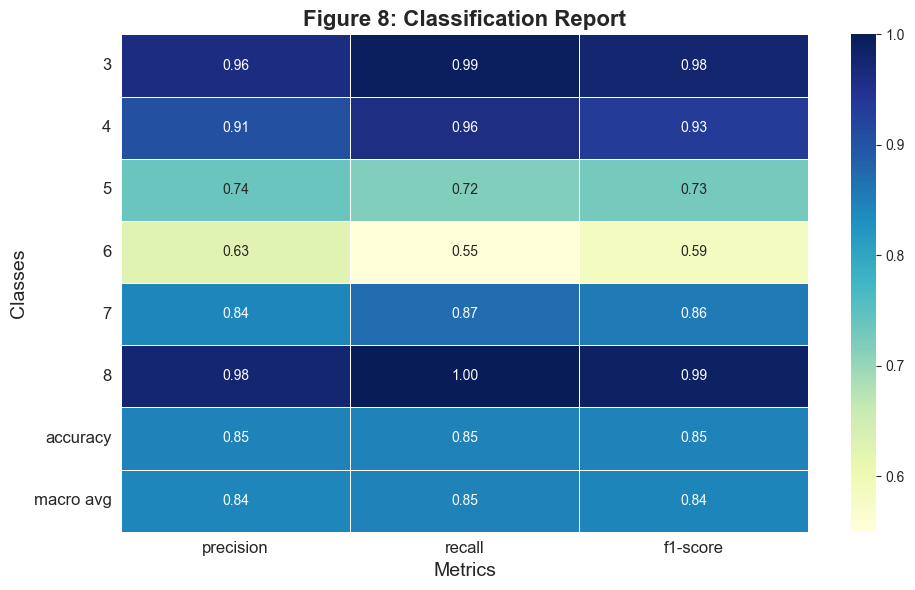

In [21]:
model = grid_search.best_estimator_
y_proba = model.predict(X_test)

y_pred = np.argmax(y_proba, axis=1)

calculate_scores(y_test, y_pred)